## Anime Face Generative Adversarial Network
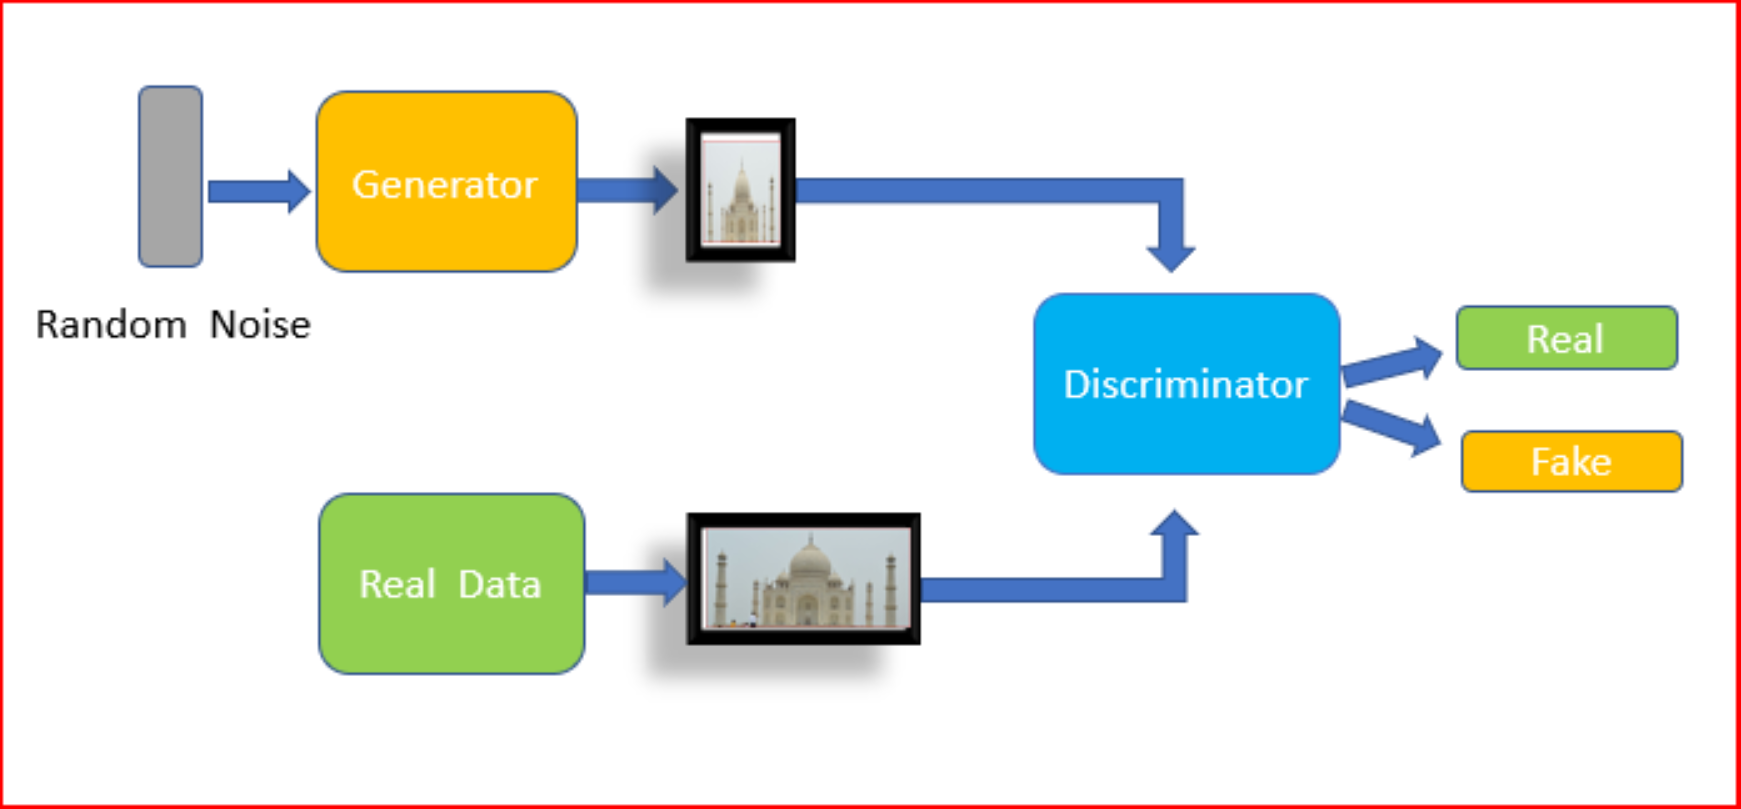

### Original Images
#### Dataset link https://www.kaggle.com/splcher/animefacedataset
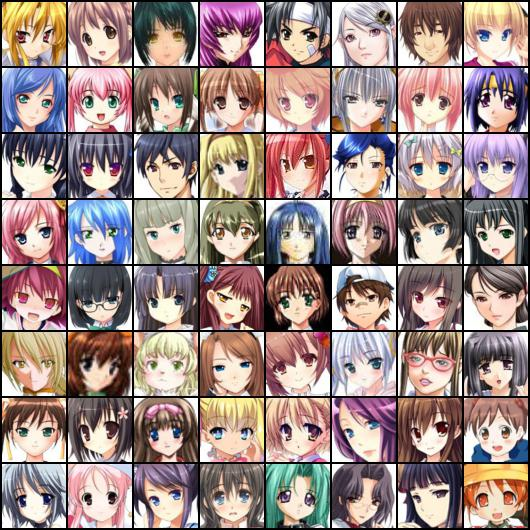

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import time
plt.rcParams.update({'axes.titlesize': 'small'})
import torch
import torch.nn as nn
from tqdm import tqdm_notebook as tqdm
import random
import os
from PIL import Image
import time
import glob

random.seed(17)
torch.manual_seed(17)

In [ ]:
IMG_ROOT = 'images'
IMG_SHAPE = 64

In [ ]:
images = glob.glob(os.path.join(IMG_ROOT, '*.*'))
data = np.zeros((56610, 3, 64, 64))
idx = 0
for image in tqdm(images):
    img = Image.open(image)
    if (img.size[0]>64) & (img.size[1]>64):
        img = img.resize((IMG_SHAPE, IMG_SHAPE))
        data[idx] = np.array(img).transpose(2, 0, 1)/255.
        idx+=1
 
data=data.astype(np.float32)
data = data*2-1
data.shape, data.min(), data.max()

In [ ]:
for idx, image in enumerate(data[4:8]):
    plt.subplot(1, 4, idx+1)
    plt.imshow(((image+1)/2).transpose(1, 2, 0))

### My First Simple GAN

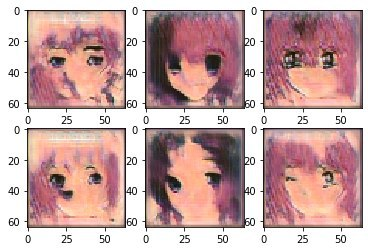

### Deep Convolutional Generative Adversial Network

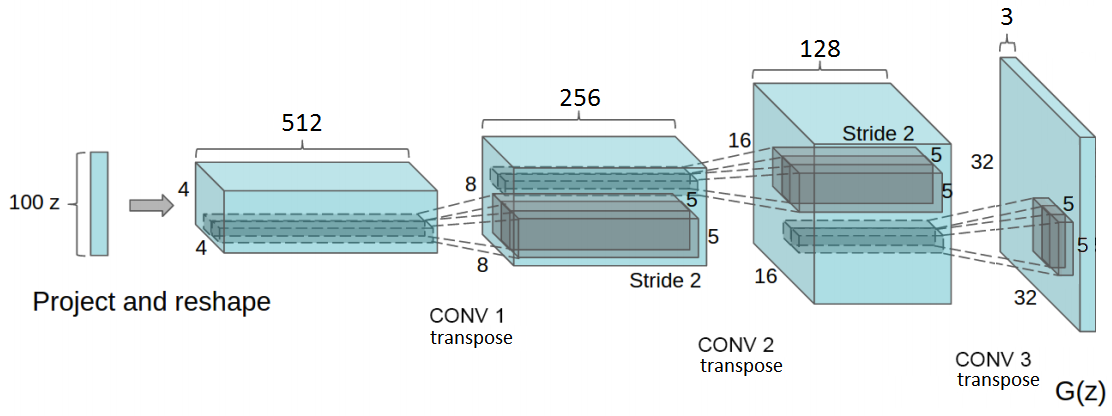

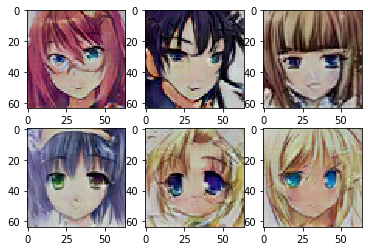

In [ ]:
class NoiseLayer(nn.Module):
    def __init__(self, std):
        super(NoiseLayer, self).__init__()
        self.std = std
    
    def forward(self, x):
      if self.training:
        return x + torch.randn(x.shape).to(device)*self.std
      return x
 
class GAN(nn.Module):
    def __init__(self, code_size):
        super(GAN, self).__init__()
        self.code_size=code_size
        self.out = nn.Sequential(nn.ConvTranspose2d(self.code_size, 512, 4, 1, bias=False), # 512x4x4
                                 nn.BatchNorm2d(512),
                                 nn.LeakyReLU(0.1, inplace=True),
                                 NoiseLayer(0.005),
                                 nn.Dropout(),
                                 nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False), # 256x8x8
                                 nn.BatchNorm2d(256),
                                 nn.LeakyReLU(0.1, inplace=True),
                                 NoiseLayer(0.005),
                                 nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False), # 128x16x16
                                 nn.BatchNorm2d(128),
                                 nn.LeakyReLU(0.1, inplace=True),
                                 NoiseLayer(0.005),
                                 nn.Dropout(),
                                 nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False), # 64x32x32
                                 nn.BatchNorm2d(64),
                                 nn.LeakyReLU(0.1, inplace=True),
                                 NoiseLayer(0.005),
                                 nn.ConvTranspose2d(64, 3, 4, 2, 1, bias=False), # 3x64x64
                                 nn.Tanh()
                                )
        
    def forward(self, x):
        x = torch.reshape(x, (x.shape[0], self.code_size, 1, 1))
        x = self.out(x)
        
        return x
        
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.out = nn.Sequential(nn.Conv2d(3, 64, 4, 2, 1, bias=False), # 64x32x32
                                 nn.LeakyReLU(0.2, inplace=True),
                                 nn.Conv2d(64, 128, 4, 2, 1, bias=False), # 128x16x16
                                 nn.BatchNorm2d(128),
                                 nn.LeakyReLU(0.2, inplace=True),
                                 nn.Conv2d(128, 256, 4, 2, 1, bias=False), # 256x8x8
                                 nn.BatchNorm2d(256),
                                 nn.LeakyReLU(0.2, inplace=True),
                                 nn.Conv2d(256, 512, 4, 2, 1, bias=False), # 512x4x4
                                 nn.BatchNorm2d(512),
                                 nn.LeakyReLU(0.2, inplace=True),
                                 nn.Conv2d(512, 1, 4, bias=False), # 1x1x1
                                 nn.Sigmoid()
                                )
        
    def forward(self, x):
        x = self.out(x)
        
        return x

In [ ]:
def init_weights(model):
  classname = model.__class__.__name__
  if classname.find('Conv') != -1:
    nn.init.normal_(model.weight.data, 0.0, 0.02)
  elif classname.find('BatchNorm') != -1:
        nn.init.normal_(model.weight.data, 1.0, 0.02)
        nn.init.constant_(model.bias.data, 0)

In [ ]:
CODE_SIZE = 100
generator = GAN(CODE_SIZE)
discriminator = Discriminator()
generator.apply(init_weights)
discriminator.apply(init_weights)

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
generator = generator.to(device)
discriminator = discriminator.to(device)
criterion = nn.BCELoss()
d_optim = torch.optim.Adam(discriminator.parameters(), lr=2e-4, betas=(0.5, 0.999))
g_optim = torch.optim.Adam(generator.parameters(), lr=2e-4, betas=(0.5, 0.999))

In [ ]:
def sample_noise_batch(bsize):
    return np.random.normal(size=(bsize, CODE_SIZE)).astype('float32')
 
def sample_data_batch(bsize):
    idxs = np.random.choice(np.arange(data.shape[0]), size=bsize)
    return data[idxs]
 
def sample_images(nrow, ncol, noise, sharp=False):
    images = generator(torch.from_numpy(noise).to(device)).cpu().detach().numpy()
    if np.var(images)!=0:
        images = images.clip(np.min(data),np.max(data))
    for i in range(nrow*ncol):
        plt.subplot(nrow,ncol,i+1)
        if sharp:
            plt.imshow(((images[i]+1)/2).transpose(1, 2, 0), interpolation="none")
        else:
            plt.imshow(((images[i]+1)/2).transpose(1, 2, 0))
    plt.show()
 
def sample_probas(bsize):
    plt.title('Generated vs real data')
    plt.hist(discriminator(torch.from_numpy(sample_data_batch(bsize)).to(device)).view(-1).cpu().detach().numpy(),
             label='D(x)', alpha=0.5,range=[0,1])
    plt.hist(discriminator(generator(torch.from_numpy(sample_noise_batch(bsize)).to(device))).view(-1).cpu().detach().numpy(),
             label='D(G(z))',alpha=0.5,range=[0,1])
    plt.legend(loc='best')
    plt.show()

In [ ]:
epochs = 400
VALIDATE_NOISE=sample_noise_batch(6)
start_epoch = 0
batch_size=128
generator_losses = []
discriminator_losses = []
for epoch in tqdm(range(start_epoch, epochs)):
    idx = np.random.permutation(np.arange(0, data.shape[0]))
    start = time.time()
    for i, batch in enumerate(range(0, data.shape[0], batch_size)):  
        X_train = torch.from_numpy(data[idx[batch:batch+batch_size]]+(np.random.normal(size=(len(idx[batch:batch+128]), 3, IMG_SHAPE, IMG_SHAPE), scale=0.02).astype(np.float32)*1/(1+np.log(epoch+10)))).to(device)
        X_train = torch.from_numpy(data[idx[batch:batch+batch_size]]).to(device)
        noise = torch.from_numpy(sample_noise_batch(X_train.shape[0])).to(device)
        
        discriminator.zero_grad()
        output_real = discriminator(X_train).view(-1)
        loss_real = criterion(output_real, torch.FloatTensor(X_train.shape[0]).uniform_(0.9, 1.).to(device))
        loss_real.backward()
    
        gen = generator(noise)
        output_fake = discriminator(gen.detach()).view(-1)
        loss_fake = criterion(output_fake, torch.FloatTensor(X_train.shape[0]).uniform_(0., 0.1).to(device))
        loss_fake.backward()
        d_optim.step()
        
        generator.zero_grad()
        output = discriminator(gen).view(-1)
        g_loss = criterion(output, torch.ones(X_train.shape[0]).to(device))
        g_loss.backward()
        g_optim.step()
 
        discriminator_losses.append(loss_real.mean().item() + loss_fake.mean().item())
        generator_losses.append(g_loss.mean().item())
    
    if epoch % 25 == 0:
        print(epoch, 'time: ', time.time()-start, 'Discriminator loss: {} Generator Loss: {}'.format(loss_real.mean().item() + loss_fake.mean().item(),
                                                                                                      g_loss.mean().item()))
        generator.eval()
        discriminator.eval()
        with torch.no_grad():
          sample_images(2,3, VALIDATE_NOISE, True)
          sample_probas(1000)
        
        generator.train()
        discriminator.train()

### Original
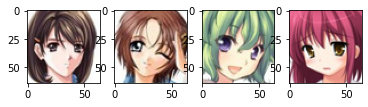

### Simple GAN
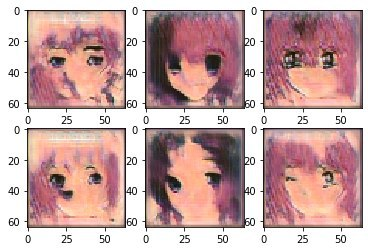

### DCGAN
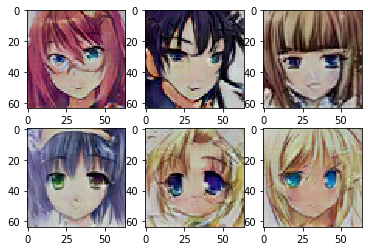

### Modified DCGAN
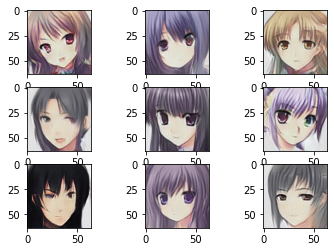

### Another person's GAN
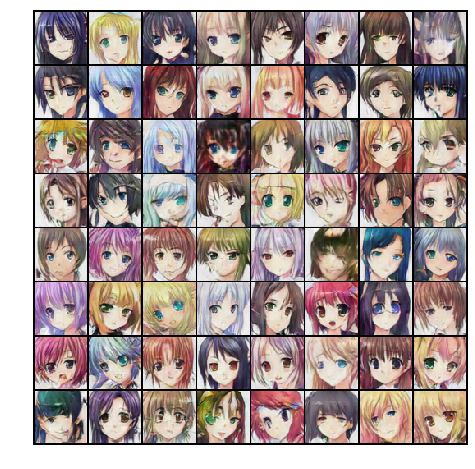